# GESTURE BASED UI DEVELOPMENT
***Project One, Comparing Different Algorithm***


## **Import Libraries and Set Random Seed**

We import necessary libraries for data handling, visualization, preprocessing, and model building. We set the seed to 403092 for reproducibility.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For scaling and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from skipy.stats import ttest_rel

# Set the random seed for reproducibility
seed = 403092
np.random.seed(seed)

## **Load the Dataset, Feature Names, and Targets**

We read the three text files.

- `dataset.txt` is loaded as a DataFrame using whitespace as delimiter.
- `features.txt` provides the names for each column.
- `targets.txt` holds the class labels for each sample.

In [4]:
# Load the dataset (assumed to be space-separated, no header)
data = pd.read_csv('data/dataset.txt', delim_whitespace=True, header=None)

# Load the features; the file contains an index and a feature name
features = pd.read_csv('data/features.txt', header=None, delim_whitespace=True)
feature_names = features[1].tolist()  # second column has feature names

# Assign column names to the dataset
data.columns = feature_names

# Load the targets (labels) - assume one label per row
targets = pd.read_csv('data/targets.txt', header=None)
targets.columns = ['Activity']

# Combine the dataset and targets into one DataFrame
data['Activity'] = targets['Activity']

# Display the shape and first few rows to verify
print("Data shape:", data.shape)
print(data.head())

/tmp/ipykernel_4947/3878997832.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('data/dataset.txt', delim_whitespace=True, header=None)


Data shape: (10299, 562)
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-m

/tmp/ipykernel_4947/3878997832.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv('data/features.txt', header=None, delim_whitespace=True)


## **Exploratory Data Analysis and Visualization**
We check for missing values, review data statistics, and plot the distribution of activities.

Missing values in each column:
0
Summary statistics:
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       10299.000000       10299.000000       10299.000000   
mean            0.274347          -0.017743          -0.108925   
std             0.067628           0.037128           0.053033   
min            -1.000000          -1.000000          -1.000000   
25%             0.262625          -0.024902          -0.121019   
50%             0.277174          -0.017162          -0.108596   
75%             0.288354          -0.010625          -0.097589   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      10299.000000      10299.000000      10299.000000      10299.000000   
mean          -0.607784         -0.510191         -0.613064         -0.633593   
std            0.438694          0.500240          0.403657          0.413333   
min           -1.000000     

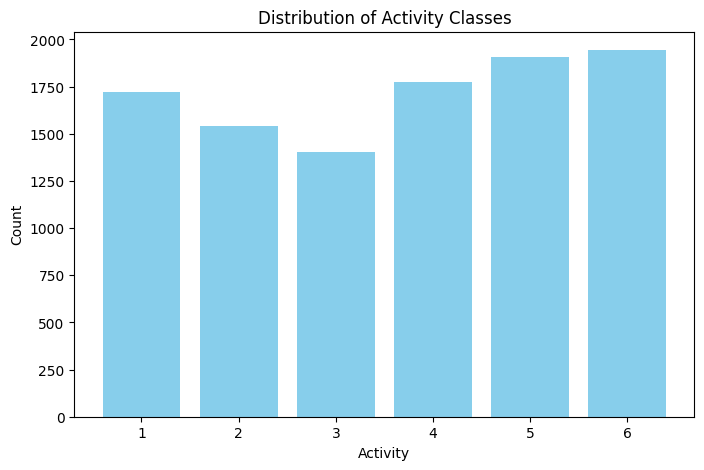

In [5]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum().sum())

# Summary statistics for numerical features
print("Summary statistics:")
print(data.describe())

# Plot the distribution of target classes (activities)
activity_counts = data['Activity'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(activity_counts.index.astype(str), activity_counts.values, color='skyblue')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Distribution of Activity Classes')
plt.show()


## **Data Preprocessing: Scaling and Splitting**
We perform feature scaling using StandardScaler and split the data into training and testing sets.
Note that we drop the target column from the feature set before scaling.

In [6]:
# Separate features and target variable
X = data.drop('Activity', axis=1)
y = data['Activity']

# Check for imbalance in classes
print("Class distribution:")
print(y.value_counts())

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Class distribution:
Activity
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64


## **Model Training and Cross-Validation Evaluation**
We now train three classifiers (SVM, Random Forest, kNN) using 5-fold stratified cross-validation.
We test different settings for SVM by using the RBF kernel (you can try others later if needed).

In [7]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Define models
svm_model = SVC(kernel='rbf', random_state=seed)  # Using RBF kernel
rf_model = RandomForestClassifier(random_state=seed)
knn_model = KNeighborsClassifier()

# Evaluate SVM using cross_val_score (accuracy)
svm_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print("SVM Accuracy (mean ± std): {:.4f} ± {:.4f}".format(svm_scores.mean(), svm_scores.std()))

# Evaluate Random Forest
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')  
# Note: RF may not require scaling, so we use original features.
print("Random Forest Accuracy (mean ± std): {:.4f} ± {:.4f}".format(rf_scores.mean(), rf_scores.std()))

# Evaluate kNN (using scaled data)
knn_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print("kNN Accuracy (mean ± std): {:.4f} ± {:.4f}".format(knn_scores.mean(), knn_scores.std()))


SVM Accuracy (mean ± std): 0.9736 ± 0.0062
Random Forest Accuracy (mean ± std): 0.9711 ± 0.0054
kNN Accuracy (mean ± std): 0.9517 ± 0.0057


## **Train Final Models and Compare on the Test Set**
After cross-validation, we retrain each model on the entire training set and evaluate their performance on the test set using various metrics.

In [8]:
# Train SVM on the entire training set
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

# Compute performance metrics for each model
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred, average='weighted')
svm_recall = recall_score(y_test, svm_pred, average='weighted')
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

print("\nSVM Metrics:")
print("Accuracy: {:.4f}".format(svm_accuracy))
print("Precision: {:.4f}".format(svm_precision))
print("Recall: {:.4f}".format(svm_recall))
print("F1 Score: {:.4f}".format(svm_f1))


SVM Metrics:
Accuracy: 0.9780
Precision: 0.9780
Recall: 0.9780
F1 Score: 0.9780


In [9]:
# Train Random Forest on the entire training set
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Compute performance metrics for each model
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print("\nRandom Forest Metrics:")
print("Accuracy: {:.4f}".format(rf_accuracy))
print("Precision: {:.4f}".format(rf_precision))
print("Recall: {:.4f}".format(rf_recall))
print("F1 Score: {:.4f}".format(rf_f1))


Random Forest Metrics:
Accuracy: 0.9751
Precision: 0.9752
Recall: 0.9751
F1 Score: 0.9751


In [10]:
# Train kNN on the entire training set
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred, average='weighted')
knn_recall = recall_score(y_test, knn_pred, average='weighted')
knn_f1 = f1_score(y_test, knn_pred, average='weighted')

print("\nKNN Metrics:")
print("Accuracy: {:.4f}".format(knn_accuracy))
print("Precision: {:.4f}".format(knn_precision))
print("Recall: {:.4f}".format(knn_recall))
print("F1 Score: {:.4f}".format(knn_f1))


KNN Metrics:
Accuracy: 0.9612
Precision: 0.9613
Recall: 0.9612
F1 Score: 0.9612


In [11]:
# Store metrics for comparison in a dictionary
results = {
    "SVM": {"Accuracy": svm_accuracy, "Precision": svm_precision, "Recall": svm_recall, "F1": svm_f1},
    "Random Forest": {"Accuracy": rf_accuracy, "Precision": rf_precision, "Recall": rf_recall, "F1": rf_f1},
    "KNN": {"Accuracy": knn_accuracy, "Precision": knn_precision, "Recall": knn_recall, "F1": knn_f1}
}

# Identify and print the best model for each metric
metrics = ["Accuracy", "Precision", "Recall", "F1"]
print("\nBest Model for Each Metric:")
for metric in metrics:
    best_model = max(results, key=lambda model: results[model][metric])
    best_value = results[best_model][metric]
    print(f"{metric}: {best_model} with value {best_value:.4f}")


Best Model for Each Metric:
Accuracy: SVM with value 0.9780
Precision: SVM with value 0.9780
Recall: SVM with value 0.9780
F1: SVM with value 0.9780


## **Confusion Matrix for the Best Model**
Based on the evaluation metrics, select the best performing model (here you can choose the one with the highest accuracy) and plot its confusion matrix.

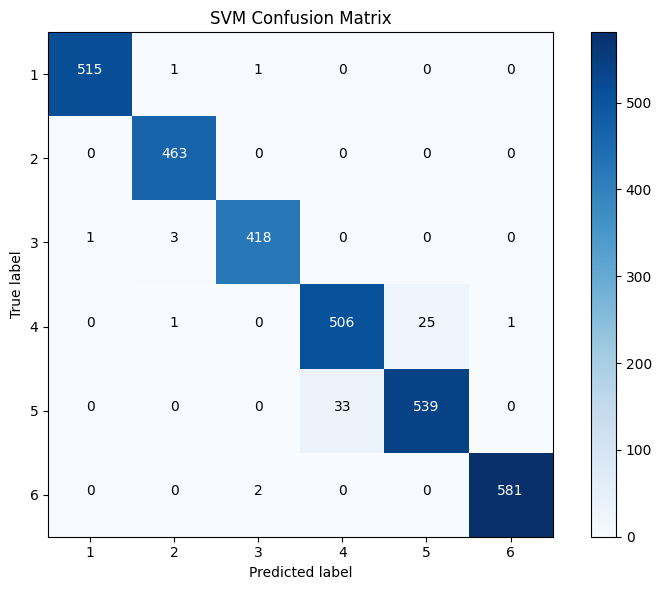

In [12]:
# For illustration, let's assume SVM performed the best.
# Compute confusion matrix for SVM on test set.
cm = confusion_matrix(y_test, svm_pred)

# Plot confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y).astype(str))
plt.yticks(tick_marks, np.unique(y).astype(str))

# Add text annotations in the cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

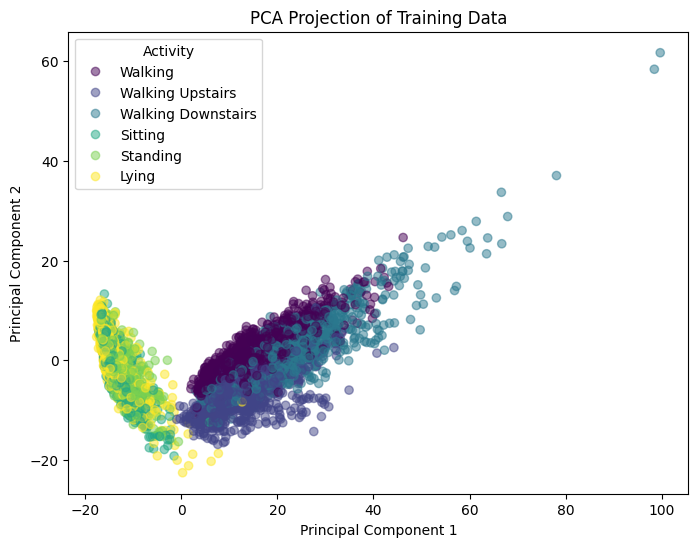

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Mapping from numeric labels to activity names
activity_names = {
    1: "Walking",
    2: "Walking Upstairs",
    3: "Walking Downstairs",
    4: "Sitting",
    5: "Standing",
    6: "Lying"
}

# Apply PCA to reduce features to 2 components for visualization
pca = PCA(n_components=2, random_state=seed)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Training Data")

# Extract the handles from the scatter plot legend elements
handles, _ = scatter.legend_elements()

# Sort unique labels from the training data
unique_labels = sorted(set(y_train))
# Map these labels to their corresponding activity names
legend_labels = [activity_names[label] for label in unique_labels]

plt.legend(handles, legend_labels, title="Activity")
plt.show()


## Hyperparameter Tuning

In [14]:
# Define hyperparameter grids
svm_params = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

rf_params = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


### Perform Grid Search or Randomized Search (Faster, Good Approximation)

In [15]:
from sklearn.model_selection import RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [16]:
# Randomized Search for SVM
random_svm = RandomizedSearchCV(SVC(), svm_params, n_iter=10, cv=cv, scoring='accuracy', n_jobs=-1, random_state=seed)
random_svm.fit(X_train_scaled, y_train)
print("Best SVM Parameters:", random_svm.best_params_)

Best SVM Parameters: {'kernel': 'linear', 'gamma': 1, 'C': 1}


In [17]:
# Randomized Search for Random Forest
random_rf = RandomizedSearchCV(RandomForestClassifier(random_state=seed), rf_params, n_iter=10, cv=cv, scoring='accuracy', n_jobs=-1)
random_rf.fit(X_train, y_train)
print("Best RF Parameters:", random_rf.best_params_)

Best RF Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}


In [18]:
# Randomized Search for kNN
random_knn = RandomizedSearchCV(KNeighborsClassifier(), knn_params, n_iter=10, cv=cv, scoring='accuracy', n_jobs=-1)
random_knn.fit(X_train_scaled, y_train)
print("Best kNN Parameters:", random_knn.best_params_)


Best kNN Parameters: {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'}


### Train the Final Model Using the Best Parameters

In [19]:
# Train SVM with best parameters
best_svm = SVC(**random_svm.best_params_, random_state=403092)
best_svm.fit(X_train_scaled, y_train)

SVC(C=1, gamma=1, kernel='linear', random_state=403092)

In [20]:
# Train Random Forest with best parameters
best_rf = RandomForestClassifier(**random_rf.best_params_, random_state=403092)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       random_state=403092)

In [21]:
# Train kNN with best parameters
best_knn = KNeighborsClassifier(**random_knn.best_params_)
best_knn.fit(X_train_scaled, y_train)


KNeighborsClassifier(metric='manhattan', n_neighbors=3)

In [22]:
# Predictions
svm_preds = best_svm.predict(X_test_scaled)
rf_preds = best_rf.predict(X_test)
knn_preds = best_knn.predict(X_test_scaled)

# Metrics function
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

# Collect metrics
metrics = {
    "SVM": compute_metrics(y_test, svm_preds),
    "Random Forest": compute_metrics(y_test, rf_preds),
    "kNN": compute_metrics(y_test, knn_preds)
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.round(4)
display(metrics_df)


,Accuracy,Precision,Recall,F1 Score
SVM,0.9816,0.9816,0.9816,0.9816
Random Forest,0.9770,0.9771,0.9770,0.9770
kNN,0.9754,0.9754,0.9754,0.9754


In [38]:
# svm_scores, rf_scores, and knn_scores (each an array of accuracy values)
t_svm_rf, p_svm_rf = ttest_rel(svm_scores, rf_scores)
t_svm_knn, p_svm_knn = ttest_rel(svm_scores, knn_scores)

# Format results
t_test_results = pd.DataFrame({
    "Comparison": ["SVM vs RF", "SVM vs kNN"],
    "t-statistic": [round(t_svm_rf, 3), round(t_svm_knn, 3)],
    "p-value": [round(p_svm_rf, 4), round(p_svm_knn, 4)]
})

print(t_test_results)


   Comparison  t-statistic  p-value
0   SVM vs RF        0.904   0.4171
1  SVM vs kNN        6.097   0.0037
